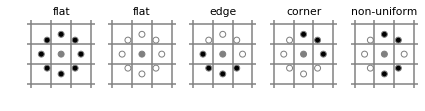

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

METHOD = 'uniform'
plt.rcParams['font.size'] = 9


def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)


def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(8),
                   np.ones(8),
                   np.hstack([np.ones(4), np.zeros(4)]),
                   np.hstack([np.zeros(3), np.ones(5)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)

(1024, 1024, 4)


D:\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


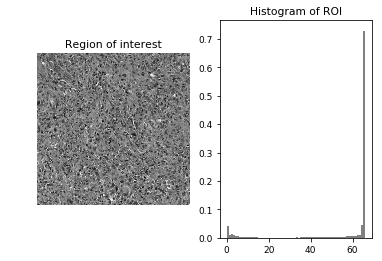

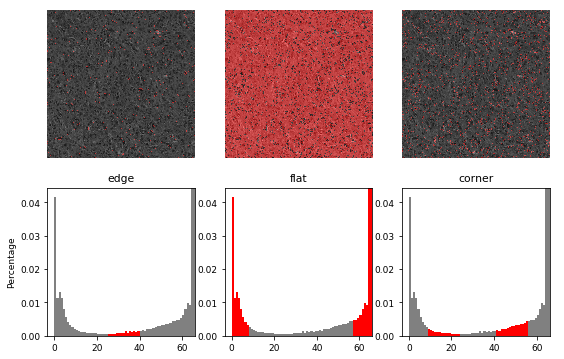

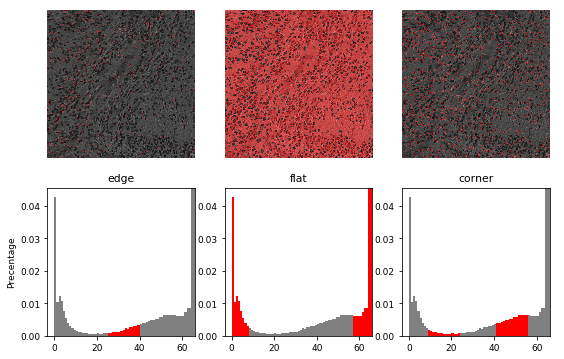

In [10]:
import os
from skimage.color import rgba2rgb
from skimage.color import rgb2gray
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 8
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


image = data.load('D:/CMU/GitHubSync/survival_analysisXdeep_learning/statistical_analysis/dataset/TCGA-06-0176-survived2700days.png')
image1 = data.load('D:/CMU/GitHubSync/survival_analysisXdeep_learning/statistical_analysis/dataset/TCGA-06-0750-01Z-00-survived28days.png')
print(image.shape)
sub_ax0 = plt.figure(0).add_subplot(121)

sub_ax1 = plt.figure(0).add_subplot(122)

plt.gray()

image = rgb2gray(rgba2rgb(image))
sub_ax0.imshow(image)
sub_ax0.axis('off')
sub_ax0.set_title('Region of interest')
image1 = rgb2gray(rgba2rgb(image1))
lbp = local_binary_pattern(image, n_points, radius, METHOD)
lbp1 = local_binary_pattern(image1, n_points, radius, METHOD)

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

hist(sub_ax1, lbp)
sub_ax1.set_title('Histogram of ROI')
plt.figure(0).savefig('One Histology Image.png')
# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
fig1, (ax_img1, ax_hist1) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax1, labels1 in zip(ax_img1, label_sets):
    ax1.imshow(overlay_labels(image1, lbp1, labels1))
    
for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)
    
for ax, labels, name in zip(ax_hist1, label_sets, titles):
    counts, _, bars = hist(ax, lbp1)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
ax_hist1[0].set_ylabel('Precentage')
for ax in ax_img:
    ax.axis('off')
    
for ax in ax_img1:
    ax.axis('off')
    
fig.savefig('survived2700days.png')
fig1.savefig('survived27days.png')

In [1]:
from skimage import data, color, util
from skimage.restoration import denoise_tv_chambolle
from skimage.feature import hog

def task(image):
    """
    Apply some functions and return an image.
    """
    image = denoise_tv_chambolle(image[0][0], weight=0.1, multichannel=True)
    fd, hog_image = hog(color.rgb2gray(image), orientations=8,
                        pixels_per_cell=(16, 16), cells_per_block=(1, 1),
                        visualize=True)
    return hog_image


# Prepare images
hubble = data.hubble_deep_field()
width = 10
pics = util.view_as_windows(hubble, (width, hubble.shape[1], hubble.shape[2]), step=width)

def classic_loop():
    for image in pics:
        task(image)


%timeit classic_loop()

def comprehension_loop():
    [task(image) for image in pics]

%timeit comprehension_loop()

from joblib import Parallel, delayed
def joblib_loop():
    Parallel(n_jobs=4)(delayed(task)(i) for i in pics)

%timeit joblib_loop()

D:\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


2.4 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


D:\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


2.41 s ± 30.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.02 s ± 83.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: grass
(171, 171)
16
4


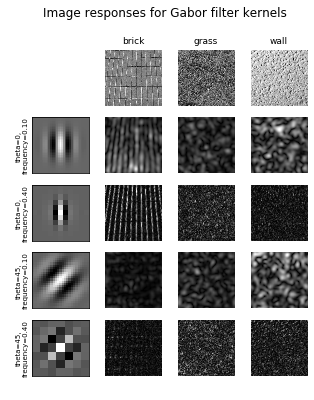

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from matplotlib import pyplot as plt


def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats, filtered


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


shrink = (slice(0, None, 3), slice(0, None, 3))
brick = img_as_float(data.load('brick.png'))[shrink]
grass = img_as_float(data.load('grass.png'))[shrink]
wall = img_as_float(data.load('rough-wall.png'))[shrink]
image_names = ('brick', 'grass', 'wall')
images = (brick, grass, wall)

# prepare reference features
ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :], filtered = compute_feats(brick, kernels)

ref_feats[1, :, :], filtered = compute_feats(grass, kernels)

ref_feats[2, :, :], filtered = compute_feats(wall, kernels)

print('Rotated images matched against references using Gabor filter banks:')

print('original: brick, rotated: 30deg, match result: ', end='')
feats, filtered = compute_feats(ndi.rotate(brick, angle=190, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: brick, rotated: 70deg, match result: ', end='')
feats, filtered = compute_feats(ndi.rotate(brick, angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: grass, rotated: 145deg, match result: ', end='')
feats, filtered = compute_feats(ndi.rotate(grass, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])
print(filtered.shape)

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))
print(len(kernels))
print(len(results))
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(5, 6))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

D:\anaconda3\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


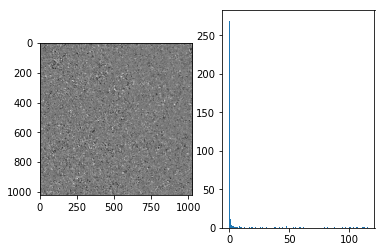

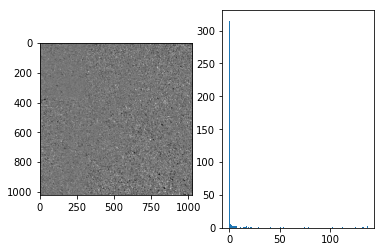

In [23]:
import os
from skimage.color import rgba2rgb
from skimage.color import rgb2gray
from skimage.transform import rotate
from skimage.feature import hog
from skimage import data
from skimage.color import label2rgb
from sklearn import svm
from matplotlib import pyplot as plt
% matplotlib inline
# use 
image = data.load('D:/CMU/GitHubSync/survival_analysisXdeep_learning/statistical_analysis/dataset/TCGA-06-0176-survived2700days.png')
image1 = data.load('D:/CMU/GitHubSync/survival_analysisXdeep_learning/statistical_analysis/dataset/TCGA-06-0750-01Z-00-survived28days.png')

image = rgb2gray(rgba2rgb(image))
image1 = rgb2gray(rgba2rgb(image1))
ppc = 16
fd, image_hog = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(2, 2),block_norm= 'L2',visualise=True)
fd1, image_hog1 = hog(image, orientations=8, pixels_per_cell=(ppc, ppc), cells_per_block=(2,2), block_norm='L2', visualise=True)

_, filtered = compute_feats(image, kernels)
fig1 = plt.figure(1)
fig1.add_subplot(121).imshow(filtered)
img_hist,_ = np.histogram(filtered, bins=512, density='true')
fig1.add_subplot(122).hist(img_hist, bins=512)
plt.show()

_, filtered1 = compute_feats(image1, kernels)
fig2 = plt.figure(2)
fig2.add_subplot(121).imshow(filtered1)
plt.imshow(filtered1)
img_hist1,_ = np.histogram(filtered1, bins=512, density='true')
fig2.add_subplot(122).hist(img_hist1, bins=512)
plt.show()